# Baseline: CNN for Lidar Odometry

In [1]:
#setup
import numpy as np
# import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.io as sio

#need to have these two lines to work on my ancient 1060 3gb
#  https://stackoverflow.com/questions/43990046/tensorflow-blas-gemm-launch-failed
# physical_devices = tf.config.list_physical_devices('GPU') 
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2
%autosave 180
# %matplotlib notebook



Autosaving every 180 seconds


In [2]:
# file = "data/train_10k.npy" #has noise in readings
# file = "data/train_100k.npy" #no noise
# file = "data/train_straight_1k.npy" #no noise, no lateral movement relative to initial heading
file = "data/train_dxdy_100k.npy" #no noise, displacement in x and y relative to starting orientation

dataset = np.load(file)

In [ ]:
#combine 100k and 200k datasets
# ds2 = np.load("data/train_dxdy_100k.npy")
# dataset = np.append(dataset, ds2, axis =0)
# np.save("data/train_dxdy_300k.npy", dataset)

In [ ]:
dataset[0,100:]
np.shape(dataset)

In [ ]:
# dataset[100,:]

In [ ]:
from network import Net1, Net2

np.random.seed(1337)

#convert data from numpy to tensors
# x_train = tf.convert_to_tensor(dataset[:,:100])

#alternate dataset where we are just looking at the changes in measurement from the first sample to the 2nd
x_temp = tf.convert_to_tensor(dataset[:,:100])
x_train = np.zeros([np.shape(dataset)[0], 50])
x_train[:,:50] = x_temp[:,:50] - x_temp[:,50:100]

print(np.shape(x_train))

y_train = tf.convert_to_tensor(dataset[:,100:])

In [ ]:
model = Net1() # 50 input data (looking at differences in measurememnt between each point) 
# model = Net2() # 100 input network (looking at full data)

runLen = 30    
BS = 128 #256 #works well

def scheduler(epoch, lr):
    part1 = 2*runLen//3
    part2 = 5*runLen//6

#     part1 = runLen//3
#     part2 = 2*runLen//3

    if epoch < part1:
        lr = 0.01
        return lr
    if epoch >= part1 and epoch < part2:
        lr = 0.005
        return lr
    if epoch >= part2:
        lr = 0.001
        return lr

#TODO: figure out how to implement sample weight
# L = tf.keras.losses.MeanAbsoluteError()
# sample_weight = [0.3,0.3,0.4]
    
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
#     loss=tf.keras.losses.MeanSquaredError(),
    loss=tf.keras.losses.MeanAbsoluteError(),
#     loss = tf.keras.losses.MeanAbsolutePercentageError(),
)

summary = model.summary()
print(summary)

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

trace = model.fit(x=x_train, y=y_train, batch_size=BS, epochs=runLen, verbose=1, 
                  validation_split=0.05, callbacks = [callback], shuffle=True)


In [ ]:
model = tf.keras.models.load_model('dead_reckoning_1pt22_mse.kmod')

In [ ]:
plt.subplot(2, 1, 1)
plt.plot(trace.history['loss'], '-')
plt.plot(trace.history['val_loss'], '-')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('iteration')
plt.ylabel('loss')

In [ ]:
r = int(np.random.rand()*100)
print(y_train[r])
out = model.predict(x_train[:100])
print(out[r])

In [ ]:
test_file = "data/test_dxdy.npy"
test_dataset = np.load(test_file)
rand = int(np.shape(test_dataset)[0]*np.random.rand())

#test for standard case
# x_test = test_dataset[:,:100]
# x_test = tf.convert_to_tensor(x_test)

#test when looking at displacement between two measurements
x_temp2 = tf.convert_to_tensor(test_dataset[:,:100])
x_test = np.zeros([np.shape(test_dataset)[0], 50])
x_test[:,:50] = x_temp2[:,:50] - x_temp2[:,50:100]

y_test = test_dataset[:,100:]
y_test = tf.convert_to_tensor(y_test)
# print(y_test[rand])
print(y_train[rand])

# guess = model.predict(x_test)
guess = model.predict(x_train)
print(guess[rand])

In [ ]:
# model.save("dead_reckoning_1pt22_mse.kmod") #got this with 50 input model

Results:

Best MSE with 100k dataset: 1.36

Best MSE with 300k dataset: 1.22

## Generate Normal Distribution Ellipse

In [3]:
# %matplotlib notebook
from utils import fit_gaussian

numpts = 10
points = np.random.randn(numpts, 2)

#adds order to points
points[:,0] += np.linspace(1,10,numpts)
points[:,1] += np.linspace(0,5*np.random.randn(),numpts)
 
mu, sigma = fit_gaussian(points)
print("mu = ", mu)
print("sigma = ", sigma)

eig = np.linalg.eig(sigma)
eigenval = eig[0]
eigenvec = eig[1]

print("eigenval = ", eigenval)
print("eigenvec = ", eigenvec)


mu =  [ 5.58794491 -1.18822586]
sigma =  [[14.36022439 -2.87206717]
 [-2.87206717  1.29882527]]
eigenval =  [14.96386479  0.69518488]
eigenvec =  [[ 0.97861879  0.20568246]
 [-0.20568246  0.97861879]]


In [4]:
from utils import R
# print(eigenvec)
theta_temp = np.arcsin(eigenvec[0,1]/eigenvec[0,0])
print(theta_temp)
# print(R(theta_temp))
# print(R(np.arctan(eigenvec[0,1]/eigenvec[0,0])))

0.2117552632392105


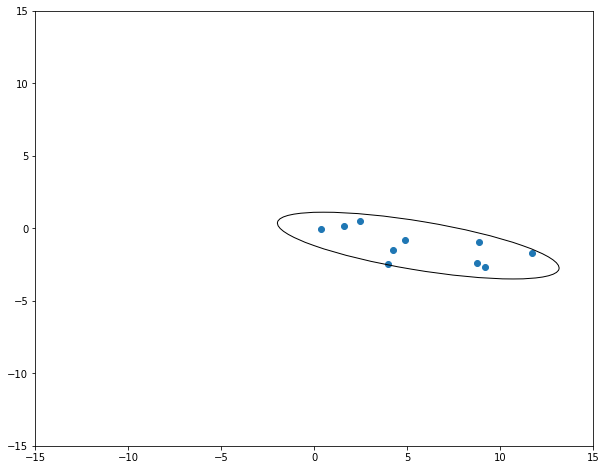

In [5]:
#draw ellipse around 1std to prove fit_guassian works
from matplotlib.patches import Ellipse
import matplotlib.patches as mpatches 

nstd = 2

fig2 = plt.figure(1)
ax2 = fig2.add_subplot()

patches = []

ax2.set_xlim(-15,15)
ax2.set_ylim(-15,15)
ax2.scatter(points[:,0], points[:,1])

rot = -np.rad2deg(np.arcsin(eigenvec[0,1]/eigenvec[0,0]))
width = 2*nstd*np.sqrt(eigenval[0])
height = 2*nstd*np.sqrt(eigenval[1])

ell = Ellipse((mu[0],mu[1]),width, height, angle = rot, fill = False)
ax2.add_patch(ell)


## Best fit ellipses directly on dataset

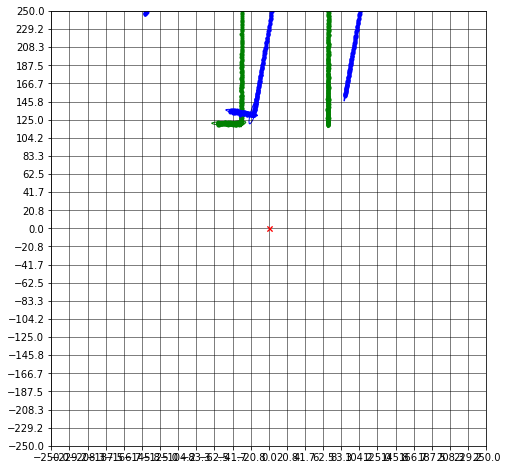

In [6]:
from utils import draw_scan, subdivide_scan

fig3 = plt.figure(1)
ax3 = fig3.add_subplot()
ax3.set_aspect('equal')
rand2 = int(np.random.rand()*50) #82 is a simple corner, 2 is a doorway
# print(rand2)

# dat = np.load("data/noisy_dxdy_100.npy") #only 50 very noisy data points
scanpts = 1000
dat = np.load("data/high_res_noisy_dxdy_100.npy") #what I had been using
# dat = np.load("data/cross_track.npy")   #new dataset

dat1 = dat[:,:scanpts]
dat2 = dat[:,scanpts:2*scanpts]

rand2 = 2 #easy test (moving away from corner)

#get point positions and draw lidar scan
pp1 = draw_scan(dat1[rand2],fig3,ax3, pt = 0) #pt0
pp2 = draw_scan(dat2[rand2],fig3,ax3, pt = 1) #pt1

f = 25 #overall region of scan is broken down into a fxf scan
E1 = subdivide_scan(pp1,fig3,ax3, nstd = 3, fidelity = f, pt =0)
E2 = subdivide_scan(pp2,fig3,ax3, nstd = 3, fidelity = f, pt =1)

# green = before
# blue = after

Note: stretched ellipses mean cov matrix is getting close to singular

## Vanilla ICP with SVD

In [ ]:
from ICP import vanilla_ICP
fig4 = plt.figure(1)
ax4 = fig4.add_subplot()
blue = mpatches.Patch(color='blue', label='Original')
green = mpatches.Patch(color='green', label='Random Transformation Applied')
red = mpatches.Patch(color='red', label='Estimated transformation')
plt.legend(handles=[green, blue, red])

#create dummy data
angle = np.pi / 4
R_true = np.array([[np.cos(angle), -np.sin(angle)], 
                   [np.sin(angle),  np.cos(angle)]])
t_true = np.array([[-2], [5]])

# Generate data as a list of 2d points
num_points = 30
true_data = np.zeros((2, num_points))
true_data[0, :] = range(0, num_points)
true_data[1, :] = 0.2 * true_data[0, :] * np.cos(0.5 * true_data[0, :]) 
# Move the data
moved_data = R_true.dot(true_data) + t_true #+ 0.5*np.random.randn(num_points) #roate and add noise
moved_data = moved_data[:,8:] #cut move dataset short
# moved_data[:, 0] = np.array([-20,5]) #create outliar at start

# Assign to variables we use in formulas.
Q = true_data
P = moved_data

green, = ax4.plot(P[0,:],P[1,:], 'g.-')
blue, = ax4.plot(Q[0,:], Q[1,:], 'b.-')


dc = False     #display correspondences
nc = 4    #number of cycles
R, t = vanilla_ICP(Q,P,fig4,ax4,draw=dc,num_cycles = nc)

print("R: ", R)
print("t: ", t)

## Apply vanilla ICP function with SVD to a noisy dataset. 
As predicted, results are not great.

In [ ]:
fig5 = plt.figure(1)
ax5 = fig5.add_subplot()
ax5.set_aspect('equal')

dc2 = False
nc2 = 3 #number of cycles

# rand3 = int(np.random.rand()*100)
rand3 = 2 #easy test
pp1 = draw_scan(dat1[rand3],fig5,ax5, pt = 0) 
pp2 = draw_scan(dat2[rand3],fig5,ax5, pt = 1)

R, t = vanilla_ICP(pp2.T,pp1.T,fig5,ax5,draw=dc2,num_cycles = nc2)
print("R: ", R)
print("t: ", t)

green = mpatches.Patch(color='green', label='1st Scan')
blue = mpatches.Patch(color='blue', label='2nd Scan')
red = mpatches.Patch(color='red', label='Estimated transformation')
plt.legend(handles=[green, blue, red])

## Apply Vanilla ICP to normal distribution ellipses

In [ ]:
fig6 = plt.figure(1)
ax6 = fig6.add_subplot()
ax6.set_aspect('equal')
rand2 = int(np.random.rand()*9) #82 is a simple corner, 2 is a doorway
green = mpatches.Patch(color='green', label='1st Scan')
blue = mpatches.Patch(color='blue', label='2nd Scan')
red = mpatches.Patch(color='red', label='Estimated transformation')
plt.legend(handles=[green, blue, red])

# rand2 = 33 #easy test (moving away from corner)

#get point positions and draw lidar scan
pp1 = draw_scan(dat1[rand2],fig6,ax6, pt = 0) 
pp2 = draw_scan(dat2[rand2],fig6,ax6, pt = 1) 

f = 8 #overall region of scan is broken down into a fxf scan
E1 = subdivide_scan(pp1,fig6,ax6, fidelity = f, pt =0)
E2 = subdivide_scan(pp2,fig6,ax6, fidelity = f, pt =1)

print(len(E1), " ellipses from first scan")
print(len(E2), " ellipses from 2nd scan")

#loop through outputs to get coords of std ellipses
s1 = np.zeros([len(E1),2])
for count, i in enumerate(E1):
    s1[count] = i[0]
s2 = np.zeros([len(E2),2])
for count, i in enumerate(E2):
    s2[count] = i[0] 

if len(s1) > len(s2):
    s1 = s1[:len(s2)]
if len(s2) > len(s1):
    s2 = s2[:len(s1)]

ax6.plot(s1[:,0],s1[:,1],'g.', markersize = 30)
ax6.plot(s2[:,0],s2[:,1],'b.', markersize = 30)
    
dc3 = False
nc3 = 1 
R, t = vanilla_ICP(s1.T,s2.T,fig6,ax6,draw=dc3,num_cycles = nc3)
print("R = ", R)
print("t = ", t)

Notes:

SVD seems to translate only on the first iteration, least squares approach will update translation estimate after each iteration

error analysis more difficult on NDT

what to do about features only detected in 2nd scan?
    after n iterations of ICP, remove features with higest error, continue calculating. 
        If performance improves, these features should remain removed, else put them back in


## Least Squares ICP

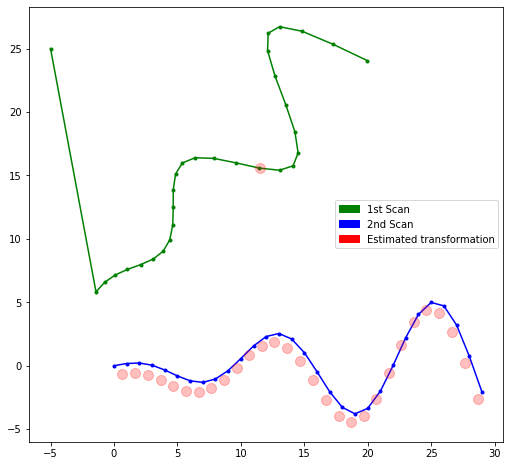

In [7]:
from  ICP import ICP_least_squares
fig7 = plt.figure(1)
ax7 = fig7.add_subplot()
ax7.set_aspect('equal')
rand2 = int(np.random.rand()*50) #82 is a simple corner, 2 is a doorway
green = mpatches.Patch(color='green', label='1st Scan')
blue = mpatches.Patch(color='blue', label='2nd Scan')
red = mpatches.Patch(color='red', label='Estimated transformation')
plt.legend(handles=[green, blue, red])

#create dummy data
angle = np.pi / 4
R_true = np.array([[np.cos(angle), -np.sin(angle)], 
                   [np.sin(angle),  np.cos(angle)]])
t_true = np.array([[-2], [5]])

# Generate data as a list of 2d points
num_points = 30
true_data = np.zeros((2, num_points))
true_data[0, :] = range(0, num_points)
true_data[1, :] = 0.2 * true_data[0, :] * np.cos(0.5 * true_data[0, :]) 
# Move the data
moved_data = R_true.dot(true_data) + t_true #+ .25*np.random.randn(num_points) #roate and add noise
# moved_data = moved_data[:,8:] #cut move dataset short
moved_data[:, 0] = np.array([-5,25]) #create outliar at start

# Assign to variables we use in formulas.
Q = true_data
P = moved_data

green, = ax7.plot(P[0,:],P[1,:], 'g.-')
blue, = ax7.plot(Q[0,:], Q[1,:], 'b.-')


NC = 10
P_corrected = ICP_least_squares(Q,P,fig7,ax7, num_cycles = NC, draw = False)

Notes about Least Squares:

Less susceptable to initial conditions

capable of working with inconsistant datasets (ex: |P| = 15, |Q| = 20)

more dependant on outliars?

### Applying Least Squares to lidar scan dataset

In [ ]:
fig8 = plt.figure()
ax8 = fig8.add_subplot()
ax8.set_aspect('equal')
green = mpatches.Patch(color='green', label='1st Scan')
blue = mpatches.Patch(color='blue', label='2nd Scan')
red = mpatches.Patch(color='red', label='Estimated transformation')
plt.legend(handles=[green, blue, red])

# rand3 = int(np.random.rand()*100)
# print("scan #: ", rand3)
rand3 = 2 #or 33 for easy test
pp1 = draw_scan(dat1[rand3],fig8,ax8, pt = 0) 
pp2 = draw_scan(dat2[rand3],fig8,ax8, pt = 1)


dc = False
nc = 10 #number of cycles
P_corrected, t, rot = ICP_least_squares(pp2.T,pp1.T,fig8,ax8, num_cycles = nc, draw = dc)
# print("t = ", t)
# print("rot = ", rot)

#### Notes:
good accuracy but SLOW

# Normal Distribution Transform (NDT)

Estimated transformation 
 [[-6.35645391 -0.70004335 -0.0571385 ]]
Actual transformation: 
 [-2.32028613 -5.57965614  0.11054518]
error: 
 [[-8.67674004 -6.27969949  0.05340668]]


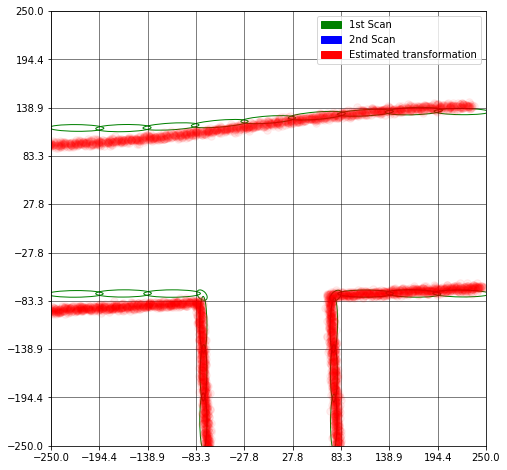

In [9]:
# from NDT import NDT_old as NDT
from NDT import NDT

fig9 = plt.figure()
ax9 = fig9.add_subplot()
# ax9.set_xlim(-125,150)
green = mpatches.Patch(color='green', label='1st Scan')
blue = mpatches.Patch(color='blue', label='2nd Scan')
red = mpatches.Patch(color='red', label='Estimated transformation')
plt.legend(handles=[green, blue, red])
ax9.set_aspect('equal') 

# a = int(100*np.random.rand())
# print(a)
a = 59 #59 #10 #97 #33 #easy test scans
fidelity = 10 # [N x N] grid of ellipses
nc = 50  # number of cycles
atd = True #along track demo

r, t, results, x_actual = NDT(dat1[a],dat2[a],fig9,ax9, fid = fidelity, 
                              num_cycles = nc, along_track_demo = atd,
                             output_actual = True)
x_est = np.array([t[0], t[1], r]).T
print("Estimated transformation \n", np.array(x_est))
print("Actual transformation: \n", x_actual)
print("error: \n", x_est + x_actual)

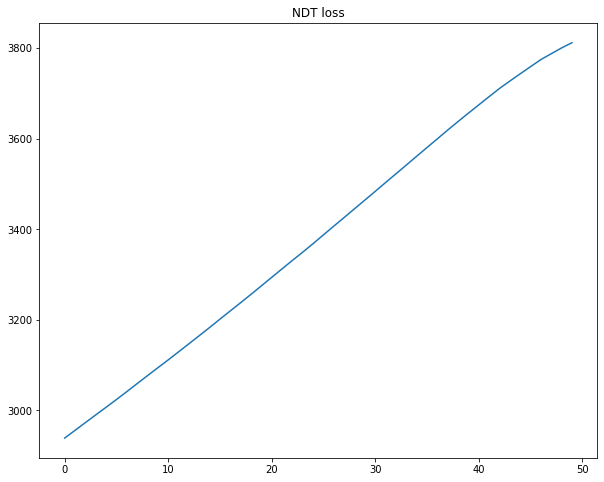

In [10]:
fig10 = plt.figure()
ax10 = fig10.add_subplot()
ax10.set_title("NDT loss")

ax10.plot(results)

# NDT Monte-Carlo Sim

In [ ]:
# from NDT import NDT_old as NDT
from NDT import NDT

fig9_2 = plt.figure()
ax9_2 = fig9_2.add_subplot()
# ax9.set_xlim(-125,150)
green = mpatches.Patch(color='green', label='1st Scan')
blue = mpatches.Patch(color='blue', label='2nd Scan')
red = mpatches.Patch(color='red', label='Estimated transformation')
plt.legend(handles=[green, blue, red])

a = 59 #59 #10 #97 #33 #easy test scans
fidelity = 10 # [N x N] grid of ellipses
nc = 250  # number of cycles in each trial
atd = True #along track demo

numTrials = 50
NDT_errors = np.zeros([numTrials,3])
for i in range(numTrials):
    r, t, results, x_actual = NDT(dat1[a],dat2[a],fig9_2,ax9_2, fid = fidelity, 
                                  num_cycles = nc, along_track_demo = atd,
                                 output_actual = True)
    x_est = np.array([t[0], t[1], r]).T
    dif = x_actual + x_est
    print("Epoch ", i)
#     print("Estimated transformation \n", x_est)
#     print("Actual transformation: \n", x_actual)
#     print("difference: \n", dif)
    NDT_errors[i,:] = dif

In [ ]:
# print(np.std(NDT_errors, axis = 0))
# print(np.shape(NDT_errors_no_outliars))
# print("with outliars:  ", np.std(NDT_errors, axis = 0))

percentile = 90
x90th = np.percentile(abs(NDT_errors[:,0]),percentile)
x_no_outliars = np.std(NDT_errors[abs(NDT_errors[:,0]) < x90th, 0 ])
y90th = np.percentile(abs(NDT_errors[:,1]),percentile)
y_no_outliars = np.std(NDT_errors[abs(NDT_errors[:,1]) < y90th, 1 ])
theta90th = np.percentile(abs(NDT_errors[:,2]),percentile)
theta_no_outliars = np.std(NDT_errors[abs(NDT_errors[:,2]) < theta90th, 2 ])

ans90th = np.array([x_no_outliars, y_no_outliars, theta_no_outliars])
print("lower ", percentile, "% STD:    ", ans90th          )

### Questions about NDT

1) NDT: It seems like optimal hyperparameter values are different between scans. Are there rules of thumb that can be used to generalize step size, etc?

2) Only works when we set minimum ellipse size (or else we could be 100 STDs away)

3) Square standard deviations (to discourage outliars)- is this like adding variances???

4) Momentum parameters for gradient descent (similar to adam?)

## Iterative Closest Ellipse Transform (ICET)

V1: ICP applied to ellipses

In [ ]:
from ICET import ICET_v1

fig11 = plt.figure()
ax11 = fig11.add_subplot()
green = mpatches.Patch(color='green', label='1st Scan')
blue = mpatches.Patch(color='blue', label='2nd Scan')
red = mpatches.Patch(color='red', label='Estimated transformation')
plt.legend(handles=[green, blue, red])

a = int(100*np.random.rand())
a = 40 #59 #10 #97 #33 #easy test scans
fidelity = 10 # [N x N] grid of ellipses
nc = 100       # number of cycles

t, rot = ICET_v1(dat1[a],dat2[a],fig11,ax11, fid = fidelity, num_cycles = nc)

### Questions about ICET

uncharacteristically wide noise distributions are anomalies for lidar point clouds -> wide distributions reflect deterministic structure in the scene

Our technique should exclude the two elongated directons but preserve the direction normal to the wall
    
    Is this just like NDT?
    
(Page 9) How can we replace y with z? if z is missing a dimension how is it useful for calculating averages?

should voxels be rigidly fixed in world space? or should they range between minimum and maximum points?

In [ ]:
from ICET import weighted_psudoinverse

H = np.array([[1, 2],[3, 4],[5, 6]])    #jacobian of first scan of points
H1 = np.array([[2, 2],[2, 3],[2, 2.5]]) #jacobian of translated points

print("H: \n", H)

W = np.identity(np.shape(H)[0]) #debug this...
print("W: \n", W)

#solves for x in Ax = b
H_w = weighted_psudoinverse(H, W) 
print("H^w: \n", H_w)


#proof this works
# print("(H^w)*H: \n", np.round(H_w.dot(H), decimals = 10))
#gets the same results as the MatLab function pinv(A) or np.linalg.pinv

#state estimate update on top of page 5 of ICET
print("dx = \n", H_w.dot(H-H1))

In [ ]:
from ICET import get_H

x = np.array([[1],[2],[0.1]])
H = get_H(P,x)
print("P: \n", P)

# print(H)
W = np.identity(np.shape(H)[0])
# print("W: \n", W)

H_w = weighted_psudoinverse(H, W) 
# print(H_w)
print("(H^w)*H: \n", np.round(H_w.dot(H), decimals = 10))

## State estimation with ICET

X = X + dx

dx = H_w(y - y0) , y & y0 are point cloud mean vectors | dx shape=[3,1]

y ~= y0 + Hdx + HOT


 corr_voxel 
 [ 1. -1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. -1. 24. 25.]
shape test (26, 2) (24, 2)


IndexError: index 24 is out of bounds for axis 0 with size 24

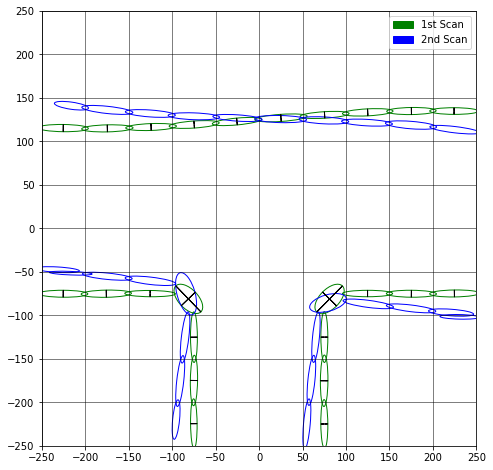

In [105]:
from ICET import ICET_v2
fig12 = plt.figure()
ax12 = fig12.add_subplot()
ax12.set_aspect('equal') 

# a = int(10*np.random.rand())
# print(a)

# dat = np.load("data/cross_track.npy")
# a = 9             #makes cross track blow up (without new L matrix)
# dat = np.load("data/cross_track_rotated.npy")

# dat = np.load("data/along_track.npy")
# a = 0 #makes along track example explode

dat = np.load("data/high_res_noisy_dxdy_100.npy") #default
a = 59            # easy test scans on default dataset: #40 #59 #10 #97 #33 

# dat = np.load("data/validation.npy")
# a = 2 #good validation example

dat1 = dat[:,:scanpts]
dat2 = dat[:,scanpts:2*scanpts]

green = mpatches.Patch(color='green', label='1st Scan')
blue = mpatches.Patch(color='blue', label='2nd Scan')
# red = mpatches.Patch(color='red', label='Estimated transformation')
# plt.legend(handles=[green, blue, red])
plt.legend(handles=[green, blue])


fidelity = 10     # [N x N] grid of ellipses
nc = 2    # number of cycles
min_num_pts = 10  # minimum number of points per ellipse #works well with 5 for default
atd = True #along track demo

if atd == True:
    X, Q, hist, x_actual, condinfo = ICET_v2(dat1[a],dat2[a],fig12,ax12, 
                                              fid = fidelity, num_cycles = nc, min_num_pts = min_num_pts, along_track_demo = atd)
    print("error: \n", x_actual+X.T)
#     print("estimate: \n", X.T)
#     print("x_actual: \n", x_actual)
else:
    X, Q, hist, condinfo = ICET_v2(dat1[a],dat2[a],fig12,ax12, 
                                    fid = fidelity, num_cycles = nc, min_num_pts = min_num_pts, along_track_demo = atd)
# print("best transformation X = \n", X.T)
# print("Q = \n", Q)

print("predicted error std: \n", np.sqrt(Q[0,0]), np.sqrt(Q[1,1]), np.sqrt(Q[2,2]))

print("L2: \n", condinfo[0])
# print("lam: \n", condinfo[1])
# print("U2: \n", condinfo[2])

x_hat_hist, y_hist, z_hist = hist
# print(y_hist)


In [67]:
#test np digitize func
x = np.array([1,2,-51,101])
bins = np.linspace(-250,250,11)
print(bins)
np.digitize(x, bins)

[-250. -200. -150. -100.  -50.    0.   50.  100.  150.  200.  250.]


array([6, 6, 4, 8], dtype=int64)

In [104]:
#np large matrix test
big_boi = np.random.randn(128000)
np.sin(big_boi**2)

array([0.69015755, 0.14800541, 0.56070154, ..., 0.00599041, 0.05903558,
       0.14158052])

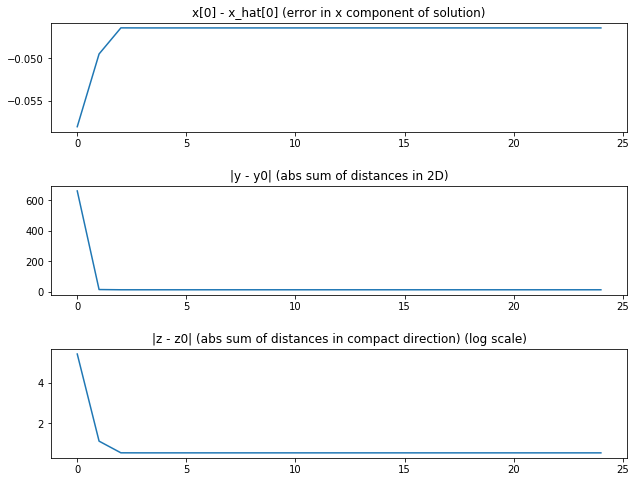

In [16]:
# fig13 = plt.figure()
# ax13 = fig13.add_subplot()
fig13, ax13 = plt.subplots(nrows = 3, ncols =1)
fig13.subplots_adjust(left = 0.1, right = 0.9, hspace = 0.5, wspace = 0.03)
ax13[0].set_title("x[0] - x_hat[0] (error in x component of solution)")
# ax13[0].set_xlabel("iteration")
# ax13[0].set_ylabel("score")
ax13[0].plot(x_hat_hist[:,0] + x_actual[0])

ax13[1].set_title("|y - y0| (abs sum of distances in 2D)")
ax13[1].plot(y_hist)

ax13[2].set_title("|z - z0| (abs sum of distances in compact direction) (log scale)")
ax13[2].plot(np.log(z_hist))
# print(x_actual)
# print(x_hat_hist)
# print(z_hist)

## ICET Monte-Carlo Sim

In [ ]:
from ICET import ICET_v2
fig12_2 = plt.figure()
ax12_2 = fig12_2.add_subplot()
ax12_2.set_aspect('equal') 

dat = np.load("data/high_res_noisy_dxdy_100.npy") #default
a = 59            # easy test scans on default dataset: #40 #59 #10 #97 #33 

dat1 = dat[:,:scanpts]
dat2 = dat[:,scanpts:2*scanpts]

green = mpatches.Patch(color='green', label='1st Scan')
blue = mpatches.Patch(color='blue', label='2nd Scan')
red = mpatches.Patch(color='red', label='Estimated transformation')
plt.legend(handles=[green, blue, red])

fidelity = 10     # [N x N] grid of ellipses
nc = 5            # number of cycles
min_num_pts = 10  # minimum number of points per ellipse #works well with 5 for default
atd = True        #along track demo

Epochs = 100
ICET_errors = np.zeros([Epochs,3])
ICET_estimated_errors = np.zeros([Epochs,3])
for i in range(Epochs):
    print("Epoch ", i)
    X, Q, hist, x_actual, condinfo = ICET_v2(dat1[a],dat2[a],fig12_2,ax12_2, fid = fidelity, 
                                              num_cycles = nc, min_num_pts = min_num_pts, 
                                              along_track_demo = atd)
#     print("best transformation X = \n", X.T)
#     print("actual: \n", x_actual)
#     print("Q = \n", Q)
    err = X.T + x_actual
#     print("error: ", err)
    ICET_errors[i,:] = err
    
    #DEBUG: switching up x and y because everything is based off of the minor axis?
#     ICET_estimated_errors[i,0] = np.sqrt(Q[1,1])
#     ICET_estimated_errors[i,1] = np.sqrt(Q[0,0])
    ICET_estimated_errors[i,0] = np.sqrt(Q[0,0])
    ICET_estimated_errors[i,1] = np.sqrt(Q[1,1])
    ICET_estimated_errors[i,2] = np.sqrt(Q[2,2])
    
print("std errors: \n", np.std(ICET_errors, axis = 0))
print("estimated std errors \n", np.mean(ICET_estimated_errors, axis = 0))
# print("estimated std errors: \n", np.std(ICET_estimated_errors, axis =0))

In [ ]:
# ICET_errors_no_outliars = ICET_errors[abs(ICET_errors[:,0]) < 3]
# print(ICET_estimated_errors)
# print(ICET_errors)

print("mean errors:       ", np.mean(ICET_errors, axis =0))

print("actual std (with outliars): ", np.std(ICET_errors, axis = 0))
# print("actual std (no outliars):   ", np.std(ICET_errors_no_outliars, axis =0))
# print(np.shape(ICET_errors_no_outliars))

print("estimated std:              ", np.mean(ICET_estimated_errors, axis = 0))
# print("estimated std errors:       ", np.std(ICET_estimated_errors, axis =0))

#calculate 90th percentile for each of the three parameters 
percentile = 90
x90th = np.percentile(abs(ICET_errors[:,0]),percentile)
x_no_outliars = np.std(ICET_errors[abs(ICET_errors[:,0]) < x90th, 0 ])
y90th = np.percentile(abs(ICET_errors[:,1]),percentile)
y_no_outliars = np.std(ICET_errors[abs(ICET_errors[:,1]) < y90th, 1 ])
theta90th = np.percentile(abs(ICET_errors[:,2]),percentile)
theta_no_outliars = np.std(ICET_errors[abs(ICET_errors[:,2]) < theta90th, 2 ])

ans90th = np.array([x_no_outliars, y_no_outliars, theta_no_outliars])
print("lower ", percentile, "% STD:    ", ans90th          )


In [ ]:
fig13, ax13 = plt.subplots(nrows = 3, ncols =1)
fig13.subplots_adjust(left = 0.1, right = 0.9, hspace = 0.5, wspace = 0.03)
# ax13.set_aspect('equal') 
# print(ICET_estimated_errors)
# print(ICET_errors)
# bins = np.linspace(1,100,50)/200 - 0.25; #for ICET_errors[:,2]
ax13[0].hist(ICET_errors[:,0], bins = 25)
ax13[0].set_title("x")
ax13[0].set_xlabel("error (m)")
ax13[0].set_ylabel("frequency")

ax13[1].hist(ICET_errors[:,1], bins = 25)
ax13[1].set_xlabel("error (m)")
ax13[1].set_title("y")
ax13[1].set_ylabel("frequency")

ax13[2].set_title("theta")
ax13[2].hist(ICET_errors[:,2], bins = 25)
ax13[2].set_xlabel("error (rad)")
ax13[2].set_ylabel("frequency")


In [ ]:
A = np.identity(2)
A[0,0] = 0.999
A[1,1] = 0.999
A[1,0] = -0.003
A[0,1] = 0.003
print(A)
# print(np.linalg.pinv(A))
# print(A.T)
B = np.array([1,0])
print(B.dot(A))

In [ ]:
 #FOUND MY BUG??!!?
# U_Test = R(np.pi/6.22)
U_Test = np.array([[0.7122, 0.6925],[-0.6925, 0.7122]]) #u matrices currently look like this (wrong)
# U_Test = np.array([[-0.8508, -0.525],[0.525, -0.8508]])
print(U_Test)
R_noise = np.array([[10.069,2.01],[-2.01,10.069]])
print(U_Test.dot(R_noise))
# print(U_Test.dot(R_noise).dot(U_Test.T))

In [ ]:
print(np.linalg.eig(arr))

In [ ]:
test = np.identity(4)
test[0,0] = 4
test[1,0] = 3
test[0,1] = 2
test[2,3] = 9
test[3,2] = -11
print(test)
print(np.linalg.pinv(test))

test2 = np.array([[4,2],
                  [3,1]])
print("test2: \n", test2)
print(np.linalg.pinv(test2))

print(np.linalg.pinv(test[:2,:2]) == np.linalg.pinv(test2))

## Proof that (H.T)(W)(H) = (U)(lam)(U.T)

In [ ]:
from utils import *

H_temp = np.random.rand(6,3)
W_temp = np.identity(6)
arr = H_temp.T.dot(W_temp).dot(H_temp)

print("arr: \n", arr)
eig = np.linalg.eig(arr)
eigenval = eig[0][:,None]
eigenvec = eig[1]

print("eigenvec: \n", eigenvec)
# print("eigenval: \n", eigenval)

lam = np.identity(3)
for i in range(3):
    lam[i,i] = eigenval[i]

print("lam: \n", lam)
    
print("ans: \n", eigenvec.dot(lam).dot(eigenvec.T))


In [ ]:
# from scipy import misc

#not going to work with our inputs

def f(x):
    #works
    return(np.sin(x+1)/4)
    
def NewtonsMethod(f, x, tolerance=0.001):
    while True:
        x1 = x - f(x) / misc.derivative(f, x) 
        t = abs(x1 - x)
        if t < tolerance:
            break
        x = x1
    return x

x = 3

x0 = NewtonsMethod(f, x)
print(x0)

In [ ]:
#ellipse z score equation

pt_x = 1
pt_y = 1.5

major = 1.94 #20
minor = 1.166 #12

ratio = major / minor

print("inside if < 1: ", (pt_x**2)/(minor**2) + (pt_y**2)/(major**2))

b = np.sqrt( (pt_x**2)/(ratio**2) + pt_y**2 )
print(b)
a = ratio*b
print(a)

print("z-score: ", a/major)

In [ ]:
from ICET import get_U_and_L

ctr1 = np.zeros([len(E1),2])
cov1 = np.zeros([len(E1),2,2])
npts1 = np.zeros(len(E1))
for idx1, c1 in enumerate(E1):
    ctr1[idx1,:] = c1[0]
    cov1[idx1,:] = c1[1]
    
U, L = get_U_and_L(cov1)
print("U[:3] = \n", U[:3], "\n L = \n", L, np.shape(L))

In [ ]:
np.linalg.pinv(np.array([[0,1],[0,1]]))

In [ ]:
from ICET import fast_weighted_psudoinverse

inpoints = np.reshape(pp1, (np.shape(pp1)[0]*2,1), order='C')

print(np.shape(inpoints))
fast_weighted_psudoinverse(inpoints,np.array([1,1,1]))

### Differentiation tests

In [ ]:
# import tensorflow as tf
# tf.compat.v1.enable_eager_execution()

# x = tf.constant([[3.0, 4.0, 10.0, 100.]])

# with tf.GradientTape() as grad:
#     grad.watch(x)
#     y = x * x
    
# dy_dx = grad.gradient(y,x)
# print(dy_dx.numpy())

# H = tf.hessians(ys, xs, gate_gradients=False, aggregation_method=None)
# print(H)

#--------------------------------------------

# import numpy as np
# # def f(x,y):
# #     return np.sin((x + y))
# # x = y = np.arange(-5, 5, 0.05)

# x = np.random.rand(3)
# y = np.random.rand(3)

# X, Y = np.meshgrid(x, y)
# print(X,"\n", Y)

# zs = np.array([f(x,y) for x,y in zip(np.ravel(X), np.ravel(Y))])
# Z = zs.reshape(X.shape)

# gx,gy = np.gradient(Z,0.05,0.05)

# print("gx: \n", gx, "\n gy: \n",gy)
#-------------------------------------------------------
import numpy as np

# arr = np.random.rand(3,3)
arr = np.linspace(0,4,5)
arr = np.array([arr,2*arr])
print("input array: \n", arr)

d1 = np.gradient(arr)
print("df/dy \n",d1[0])
print("df/dx \n", d1[1])

d2f_dx = np.gradient(d1[1])
print("d2f_dxdy \n", d2f_dx[0])
print("d2f_d2x \n", d2f_dx[1]) 

d2f_dy = np.gradient(d1[0])
print("d2f_dydx \n", d2f_dy[1])
print("d2f_d2y \n", d2f_dy[0]) 

#order of partials does not matter...
# print(d2f_dx[0] == d2f_dy[1])


In [ ]:
l1 = np.zeros([2,2])
l2 = np.ones(2)

a = []
a.append(l1)
a.append(l2)
print(a)

In [ ]:
a = np.array([[1,0]])
np.shape(a)

### Notes:

- ICET is very sensitive to voxel size:
        
            increasing voxel size can cause multiple objects to be grouped within the same ellipse, this will cause the ellipse to be rotated not in the direction of geometric ambiguity of each individual shape but merely be rotated to represent the spatial relationship between the two objects
            
            
- much better results when dividing cellsize by 2 (may be due to radius/ diameter inconsistancy)

### Questions:

- what do I do if BOTH axis of ellipse extend past the cutoff value?

- both pure cross track and pure along track will explode in some situations 

- do conditioning on each summand of first term (H_i.T)(W_i)(H_i) or at the end? 
        
        - I'm assuming the end...

- when removing axis after calculting condition number how do I know which axis are associated with each eigenvalue?

        - should I be using an identity matrix or should I just use whatever axis the eig() function puts out eigenvectors

- is the goal of the 2nd L matrix to avoid explosion or to encourage convergence? 



In [ ]:
#test
x = -np.linspace(0,10,11)
A, B, C = sorted(x)[0:3]
print(x)
print(A, B, C)

In [ ]:
np.linalg.pinv(np.identity(1))